# CATEGORIES DATA with NLP AND LSTM

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import sklearn

import os,re,datetime


## LOAD DATA

In [2]:
PATH=os.getcwd()
df=pd.read_csv(os.path.join(PATH,'dataset','ecommerceDataset.csv'),names=['categories','text'])

## INVESTIGATION

In [3]:
df.head(4)

,categories,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   categories  50425 non-null  object
 1   text        50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [5]:
df.describe().T

,count,unique,top,freq
categories,50425,4,Household,19313
text,50424,27802,Think & Grow Rich About the Author NAPOLEON HI...,30


## DATA CLEANING

### handling null value

In [6]:
print(df.isna().sum()) # check how many null

print(df[df['text'].isna()]) # check the null

categories    0
text          1
dtype: int64
                   categories text
39330  Clothing & Accessories  NaN


In [7]:
df.dropna(inplace=True)

### handling duplicate (maybe OPTIONAL)

In [8]:
df[df.duplicated()] #too much to remove 


,categories,text
7,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
11,Household,Paper Plane Design Starry Night Vangoh Wall Ar...
12,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
16,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
20,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou..."


In [9]:
print(df[df.duplicated()].value_counts())
print('======================')
print(df['categories'].value_counts())

categories              text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

## Text Preprocessing

In [10]:
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

# import nltk
#nltk.download('stopwords') IF YOU NOT HAVE YET

def remove_unwanted_string(text):
    stop_words = set(stopwords.words("english"))
    text_clean=[]

    for text_inputs in text:

        #Remove html tag 
        text_inputs = BeautifulSoup(text_inputs, 'html.parser').get_text()

        #Remove certain symbol that concern me
        text_inputs=re.sub('<.*?>'," ",text_inputs)

        #Remove all thing besides letter and numbers
        text_inputs=re.sub("[^a-zA-Z0-9]"," ",text_inputs).lower()

        #remove stop word eg. [is a was]
        words = text_inputs.split()
        words = [word for word in words if word not in stop_words]
        clean_data = " ".join(words) # Join the words back into a sentence

        # Remove extra whitespaces
        clean_data = re.sub(r"\s+", " ", clean_data).strip()

        text_clean.append(clean_data)
    return text_clean

In [11]:
df['text']=remove_unwanted_string(df['text'])

C:\Users\VP\AppData\Local\Temp\ipykernel_22636\771335289.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text_inputs = BeautifulSoup(text_inputs, 'html.parser').get_text()


## DATA PREPROCESS

In [12]:
features=df['text'].values
labels=df['categories'].values

### Label encoding

In [13]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

#Convert categorical data to int - label encoding   it like get_dummies and one hot encoding

label_encoder=LabelEncoder()
label_encoded=label_encoder.fit_transform(labels)

### Data spliting

In [14]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(features,label_encoded,test_size=.2,random_state=42)


### Tokenization

In [15]:
"""Define hyperparameter for nlp"""

#Tokenizer
vocab_size= 5000   
oov_token='<OOV>'

#padding
max_length=500

#Embeding layer dimension
embedding_dim=64

In [16]:
#Define Tokenizer
tokenizer=tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size,
    split=" ",
    oov_token=oov_token
)

tokenizer.fit_on_texts(X_train)

In [17]:
#Tranform text into token
X_train_token=tokenizer.texts_to_sequences(X_train)
X_test_token=tokenizer.texts_to_sequences(X_test)

### Padding sequence

In [18]:
X_train_padded = tf.keras.utils.pad_sequences(
    X_train_token,
    maxlen=max_length,
    padding='post',
    truncating='post'
)


X_test_padded = tf.keras.utils.pad_sequences(
    X_test_token,
    maxlen=max_length,
    padding='post',
    truncating='post'
)

## Model Developement

In [19]:
#building layer
from keras.layers import Embedding,Bidirectional,LSTM,Dense,Dropout
model=tf.keras.Sequential([
    Embedding(vocab_size,embedding_dim),             
    #idirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(32,activation='relu'),
    Dense(4,activation='softmax')
])

In [20]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy']) #model compile

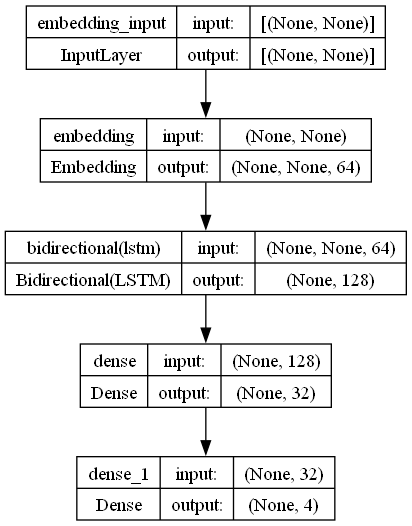

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True) #model architecture

## Model training

In [22]:
from keras.callbacks import EarlyStopping,TensorBoard

max_epoch=10
early_stopping=EarlyStopping(patience=2)

PATH=os.getcwd()
logpath=os.path.join(PATH,'tensorboard_log',datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb=TensorBoard(logpath)

history=model.fit(
    X_train_padded,y_train,
    validation_data=(X_test_padded,y_test),
    epochs=max_epoch,
    callbacks=[early_stopping,tb]
)

Epoch 1/10
1261/1261 [==============================] - 256s 199ms/step - loss: 0.2207 - accuracy: 0.9292 - val_loss: 0.1190 - val_accuracy: 0.9685
Epoch 2/10
1261/1261 [==============================] - 231s 183ms/step - loss: 0.0811 - accuracy: 0.9782 - val_loss: 0.1083 - val_accuracy: 0.9702
Epoch 3/10
1261/1261 [==============================] - 250s 198ms/step - loss: 0.0569 - accuracy: 0.9842 - val_loss: 0.1148 - val_accuracy: 0.9697
Epoch 4/10
1261/1261 [==============================] - 266s 211ms/step - loss: 0.0421 - accuracy: 0.9880 - val_loss: 0.1053 - val_accuracy: 0.9745
Epoch 5/10
1261/1261 [==============================] - 251s 199ms/step - loss: 0.0327 - accuracy: 0.9908 - val_loss: 0.1145 - val_accuracy: 0.9747
Epoch 6/10
1261/1261 [==============================] - 259s 206ms/step - loss: 0.0256 - accuracy: 0.9928 - val_loss: 0.1272 - val_accuracy: 0.9732


### Model Evaluation

In [23]:
from sklearn.metrics import classification_report

prediction=model.predict(X_test_padded)
prediction_index=np.argmax(prediction, axis=1)

report = classification_report(y_test,prediction_index)

print(report)


316/316 [==============================] - 17s 50ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2378
           1       0.99      0.97      0.98      1750
           2       0.97      0.97      0.97      2082
           3       0.97      0.98      0.97      3875

    accuracy                           0.97     10085
   macro avg       0.97      0.97      0.97     10085
weighted avg       0.97      0.97      0.97     10085



### Model PERFORMANCE

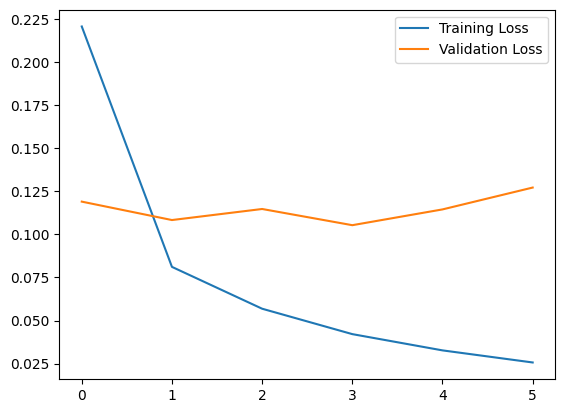

In [24]:
#loss graph
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])
plt.show()

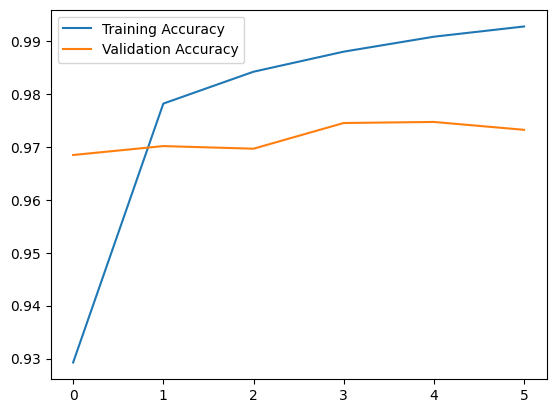

In [25]:
#accuracy graph
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

### Save Model (TOKENIZER and model)

In [26]:
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

In [27]:
# Save the model in .h5 format
model.save(os.path.join(save_dir, 'model.h5'))

In [28]:
import json

tokenizer_json = tokenizer.to_json()
with open(os.path.join(save_dir, 'tokenizer.json'), 'w', encoding='utf-8') as json_file:
    json.dump(tokenizer_json, json_file, ensure_ascii=False)